In [24]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import time
import wave
import IPython.display as ipd
import librosa.display

class Audio:
    def __init__(self):
        super(Audio, self).__init__()
        
        self.SHORT_NORMALIZE = (1.0/32768.0)
        self.RATE = 44100  
        self.INPUT_BLOCK_TIME = 0.05
        self.CHUNK = int(self.RATE*self.INPUT_BLOCK_TIME)
        self.CHANNEL = 2
        
        self.microphone_name = "3- Andrea PureAudio"

    def initiate_mic(self):
        self.pa = pyaudio.PyAudio()
        device_index = self.discover_mic()  
        self.mic = pa.open(format = pyaudio.paInt16,
                    channels = self.CHANNEL,
                    rate =  self.RATE ,
                    input = True,
                    input_device_index = device_index,
                    frames_per_buffer = self.CHUNK
                    )
        
        
    def discover_mic(self):

        for i in range(self.pa.get_device_count() ):     
            devinfo = self.pa.get_device_info_by_index(i)   

            if self.microphone_name in devinfo["name"]:
                    device_index = i
                    return device_index

    def record_audio(self, filename, runtime):

        blocks = []

        print("Recording starts..")
        st = time.time()
        while True:
            block = self.mic.read(self.CHUNK)
            blocks.append(block)

            t = time.time() - st

            if t>runtime:        
                self.save_audio(filename, blocks)        
                self.close_mic()
                break

        print("Recording done! Saved as %s", filename)

    def save_audio(self, filename, blocks):
        wf = wave.open(filename, 'wb')
        wf.setnchannels(self.CHANNEL)
        wf.setsampwidth(self.pa.get_sample_size(pyaudio.paInt16))
        wf.setframerate(self.RATE)
        wf.writeframes(b''.join(blocks))
        wf.close()

    def close_mic(self):
        self.mic.stop_stream()
        self.mic.close()
        self.pa.terminate()
        
class Visualize():
    def __init__(self):
        super(Visualize, self).__init__()
        
        plt.figure(figsize=(12, 6)) 
        
    def load_file(self, filename):
        self.x, self.sr = librosa.load(filename)
        
    def show_wave(self):
        librosa.display.waveshow(self.x, sr = self.sr)
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (scaled)")
    
    def show_spec(self):
        X = librosa.stft(self.x)
        Xdb = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
        plt.colorbar()
        plt.xlabel("Time (seconds)")
        plt.ylabel("Frequency (Hz)")

## Record audio

In [25]:
filename = "test.wav"
runtime = 5 #sec

audio = Audio()

audio.initiate_mic()
audio.record_audio(filename, runtime)
ipd.Audio(filename)

Recording starts..
Recording done! Saved as %s test.wav


## Visualize audio

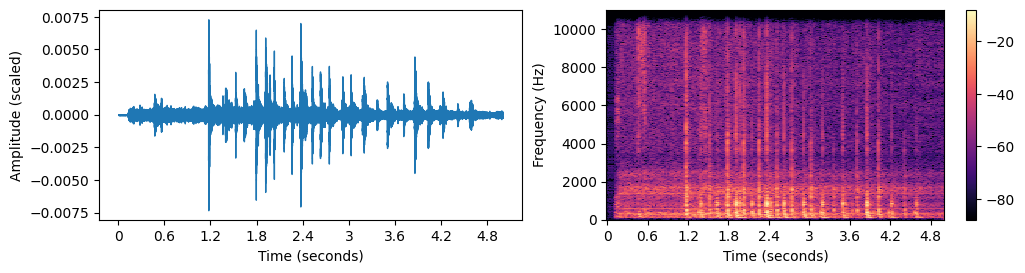

In [26]:
visual = Visualize()

filename = "test.wav"
visual.load_file(filename)

plt.subplot(2,2,1)
visual.show_wave()

plt.subplot(2,2,2)
visual.show_spec()

In [27]:
x, sr = librosa.load(filename)
zero_crossings = librosa.zero_crossings(x, pad=False)
print(sum(zero_crossings))

13340


C:\Users\Rabbi\AppData\Local\Temp\ipykernel_10420\819940035.py:3: FutureWarning: Pass y=[-3.5229730e-06 -9.4623101e-06 -3.3905148e-06 ... -9.6502235e-06
  7.3528236e-06 -1.5781694e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]


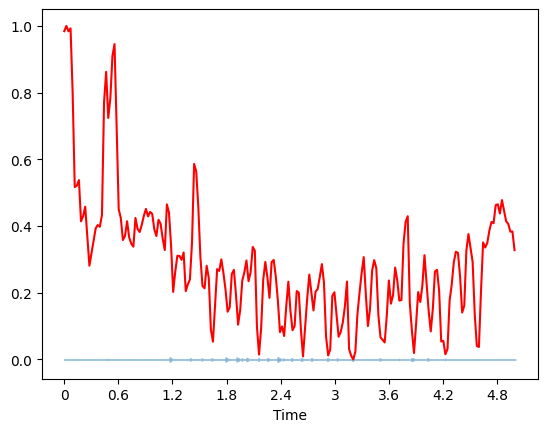

In [29]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
import sklearn
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveshow(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')